In [4]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import requests
import pprint
import difflib

In [5]:



data = pd.read_csv("vehicles.csv", header = None, skiprows=[0])
column_headers = pd.read_csv("vehicles.csv", nrows=0).columns.tolist()
data.columns = column_headers
data = data.drop(["id", "url", "region_url", "VIN", "size", "image_url", "description", "county", "lat", "long"], axis=1)
#data = data.dropna(subset=['posting_date'])
#data = data.dropna(subset=['condition'])
#drop rows where the manufacturer and model are both null (that should also eleminate rows missing the type as well)
#drop rows where both the title_status and condition are null
data = data.dropna(subset=["title_status", "condition"], how='all')
#drop rows where the posting date is null and the odometer is null
data = data.dropna(subset=["year", "odometer"], how='all')
#drop the rows where the posting date is null

#id, url, region_url, VIN, size, image_url, description, county, lat, long
#year just drop
data = data.dropna(subset=["year"])
#manufacturer fill null values by mapping the model to who is the maker of the model is - Curtis
#model drop the missing model values for now - Curtis
#condition when: - Cole
# title_status clean and odometer less than 500 set to new, 
# title_status clean and odometer less than 5000 set to like new, 
# title_status clean and odometer less than 40000 is excellent, 
# title_status clean and when the odometer is less than 80000 is good,
# title_status clean and when the odometer is less than 120000 is fair,
# title_status salvage then map to salvage
#cylinders drop the column?
#fuel just fill in as gas - Cole
#odometer fill by taking posting_date year - year x 20000 = fill value - Cole
#title_status fill: - Cole
# new, like new excellent, good and fair put as clean
# salvage as salvage
#transmission put as automatic - Curtis
#Option 1: drive taking count for region and then assigning the type based on what is most common in that region
#Option 2: take count for the vehicle type and then assign the type for what is most common for that type
#type map the model to the type - Curtis
#paint_color assign based on the type and what is the most popular for that vehicle type - Curtis

null_rows = data[data[['drive']].isnull().all(axis=1)]
# Print all rows where 'column1' and 'column2' are null
#null_rows = data[data["manufacturer"].isna() & data["type"].isna()]

#pprint.pprint(null_rows)
print(len(null_rows))
#print(data.type.value_counts())
#print(data.condition.value_counts())
#print(data.shape[0])
#display(data)


129322


In [6]:
#Curtis cell for data cleaning

#Drop all rows with no manufacturer AND no model
data = data.dropna(subset=["model", "manufacturer"], how="all")

#Find all the unique manufacturers in the Manufacturer column
unique_manufacturers = data["manufacturer"].dropna().unique().tolist()
if "ram" in unique_manufacturers:
    # Remove manufacturer "Ram" as it is to common in other words like Program
    unique_manufacturers.remove("ram")

# Function to fill missing manufacturers based on the model name
def check_manufacturer_in_model_name(data_row):
    if pd.isna(data_row["manufacturer"]) and pd.notna(data_row["model"]):
        for manufacturer in unique_manufacturers:
            if manufacturer.lower() in data_row["model"].lower():  # Case-insensitive matching
                #model_str = str(data_row["model"]) 
                #print(f"Model: {model_str} Closest Manufacturer: {manufacturer.lower()}")
                return manufacturer
    return data_row["manufacturer"]  # Return existing manufacturer if not missing

# Apply the function to update the 'manufacturer' column
data["manufacturer"] = data.apply(check_manufacturer_in_model_name, axis=1)


filtered_data = data[data["manufacturer"].notna() & data["model"].notna()]
model_to_manufacturer = filtered_data.set_index("model")["manufacturer"].to_dict()

def fill_empty_manufacturer_rows(data_row):
    if pd.isna(data_row["manufacturer"]) and pd.notna(data_row["model"]):
        closest_match = difflib.get_close_matches(
            data_row["model"], model_to_manufacturer.keys(), n=1, cutoff=0.7
        )
        if closest_match:
            #model_str = str(data_row["model"])  # Convert model to string
            #print(f"Model: {model_str} Closest Manufacturer: {model_to_manufacturer[closest_match[0]]}")
            return model_to_manufacturer[closest_match[0]]
    return data_row["manufacturer"]

data["manufacturer"] = data.apply(fill_empty_manufacturer_rows, axis=1)

null_rows = data[data[['manufacturer']].isnull().all(axis=1)]
print(f"Number of null manu: {len(null_rows)}")


#Change missing values in transmission column to automatic
data["transmission"] = data["transmission"].fillna(value="automatic")


#paint_color assign based on the type and what is the most popular for that vehicle type - Curtis


Number of null manu: 10427


In [7]:
#Curtis cell for data cleaning
# Mapping type to model and replacing all null values with the map/dictionary
filtered_data = data[data["model"].notna() & data["type"].notna()]
model_to_type = filtered_data.set_index("model")["type"].to_dict()

def fill_type(data_row):
    if data_row["model"] in model_to_type and pd.isna(data_row["type"]):
        #model_str = str(data_row["model"])  # Convert model to string
        #print(f"Model: {model_str} Closest type: {model_to_type[data_row['model']]}")
        return model_to_type[data_row["model"]]
    return data_row["type"]

# Apply the function to fill missing manufacturer values
data["type"] = data.apply(fill_type, axis=1)

null_rows = data[data[['type']].isnull().all(axis=1)]
pprint.pprint(null_rows)
print(len(null_rows))

            region      price    year manufacturer  \
96          auburn         80  2004.0        honda   
101         auburn      12990  1968.0        volvo   
195     birmingham      34995  2012.0        dodge   
242     birmingham          0  2014.0          NaN   
280     birmingham  987654321  1960.0    chevrolet   
...            ...        ...     ...          ...   
426736     wyoming      28900  2007.0         ford   
426787     wyoming      27495  2014.0    chevrolet   
426789     wyoming      11000  2017.0          NaN   
426791     wyoming      32995  2013.0         ford   
426814     wyoming      18750  2005.0          gmc   

                                 model  condition    cylinders    fuel  \
96                                 NaN  excellent  6 cylinders     gas   
101                                NaN        NaN          NaN     gas   
195                  charger limousine        NaN          NaN     gas   
242              Freightliner Cascadia        NaN      

In [8]:
unique_drivetrains = data["drive"].dropna().unique().tolist()

# Check and see if any of the unique drivetrains identified from the drive column are in the model name
pattern = '|'.join(unique_drivetrains)
data["updated_drive_train"] = data["model"].str.extract(f'({pattern})', expand=False)
pprint.pprint(data["updated_drive_train"])
data["drive"] = data["drive"].fillna(data["updated_drive_train"])
data.drop(columns=["updated_drive_train"], inplace=True)

#null_rows = data[data[['drive']].isnull().all(axis=1)]
#print(len(null_rows))

27        NaN
28        NaN
29        NaN
30        NaN
31        NaN
         ... 
426875    NaN
426876    NaN
426877    NaN
426878    NaN
426879    NaN
Name: updated_drive_train, Length: 423227, dtype: object


In [9]:
#Cole cell for data cleaning
title_status_mapping = {"new" : "clean", "like new" : "clean", "excellent" : "clean", "good" : "clean", "fair" : "clean", "salvage" : "salvage" }
def format_dates(old_format):
    new_format = old_format.split("-")
    #new_format = datetime.datetime.strptime(old_format,"%Y-%m-%dT%H:%M:%S-%f").date()
    return int(new_format[0])

def fill_conditions(data_row):
# title_status clean and odometer less than 500 set to new, 
    vehicle_condition = data_row["condition"]
    if pd.isna(data_row["condition"]) == False:
        vehicle_condition = data_row["condition"]
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 500:
        vehicle_condition = "new"
# title_status clean and odometer less than 5000 set to like new, 
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 5000:
        vehicle_condition = "like new"
# title_status clean and odometer less than 40000 is excellent, 
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 50000:
        vehicle_condition = "excellent"
# title_status clean and when the odometer is less than 80000 is good,
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] < 150000:
        vehicle_condition = "good"
# title_status clean and when the odometer is less than 120000 is fair,
    elif (data_row["title_status"] == "clean" or data_row["title_status"] == "lien" or data_row["title_status"] == "missing") and data_row["odometer"] <= 220000:
        vehicle_condition = "fair"
# title_status salvage then map to salvage
    else:
        vehicle_condition = "salvage"
    return vehicle_condition

data["fuel"] = data["fuel"].fillna(value="gas")
data["title_status"] = data["title_status"].fillna(value=data["condition"].map(title_status_mapping))
data["posting_date"] = data["posting_date"].apply(format_dates)
data["odometer"] = data["odometer"].fillna(value=(data["posting_date"] - data["year"]) * 20000)
data["condition"] = data.apply(fill_conditions, axis=1)
#print(data.isna().sum())
# null_rows = data[data[['condition']].isnull().all(axis=1)]
# print(null_rows.title_status.value_counts())
# print(data.condition.value_counts())
# print(null_rows.odometer.value_counts())

In [10]:
# Drop rows with nulls in 'type' and 'manufacturer' columns

data = data.dropna(subset=['type'])

data = data.dropna(subset=['manufacturer'])

# Drop rows where price < $500 as they are likely to be incorrect values
data = data[data['price'] >= 500]

<Figure size 640x480 with 0 Axes>

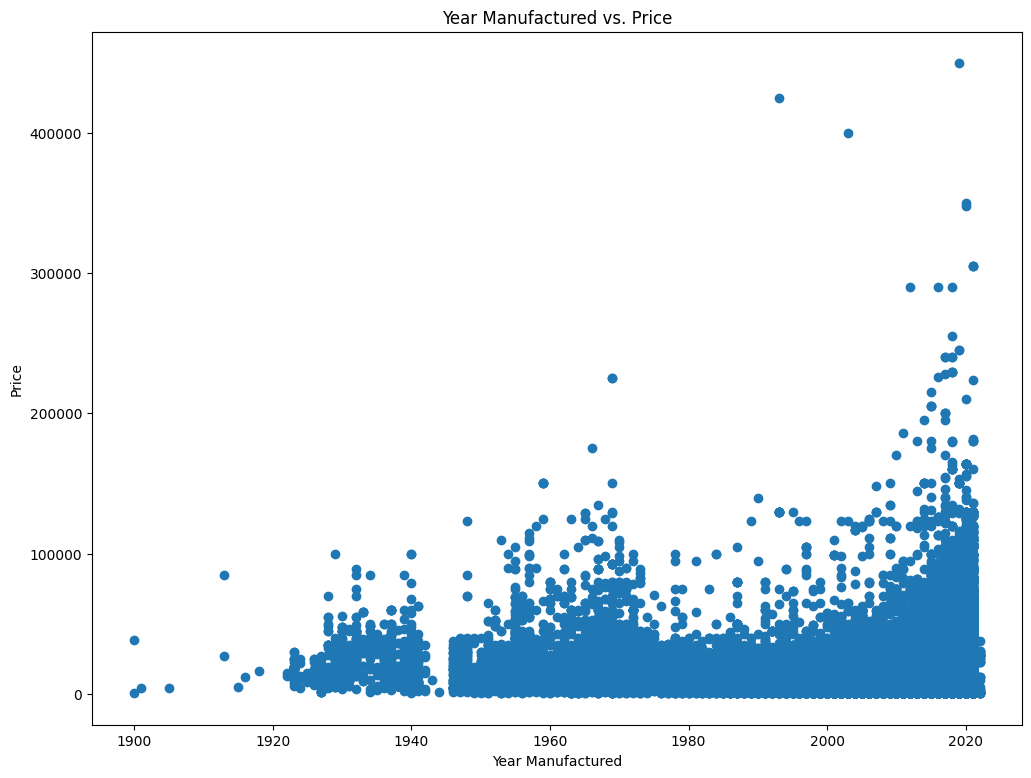

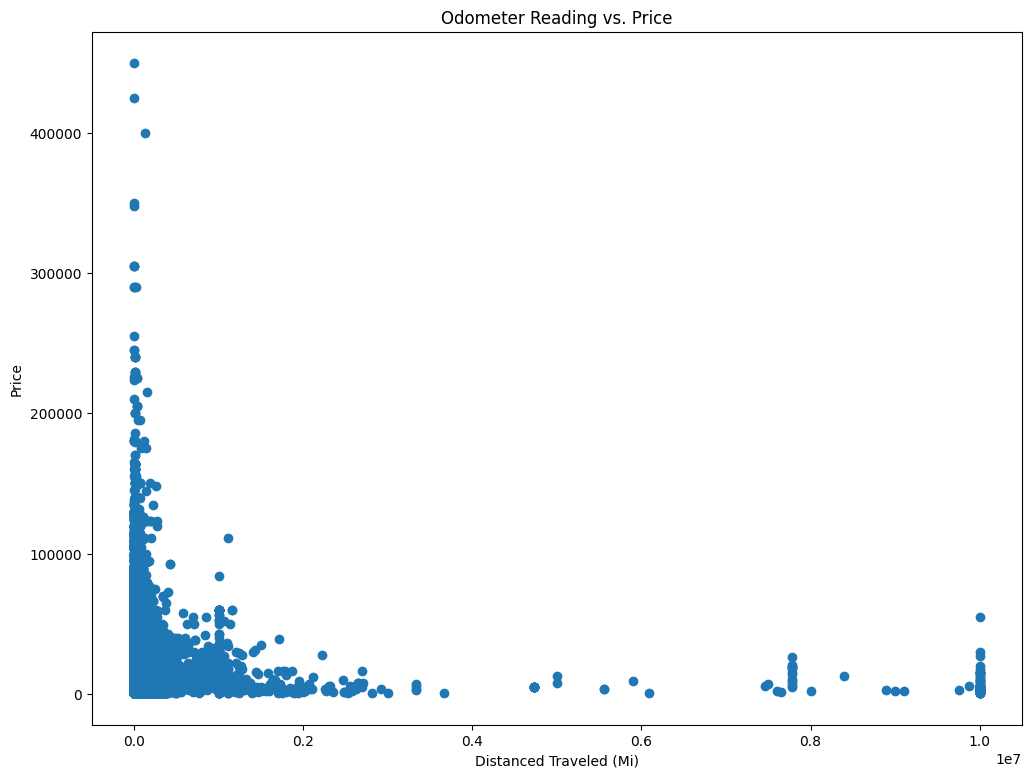

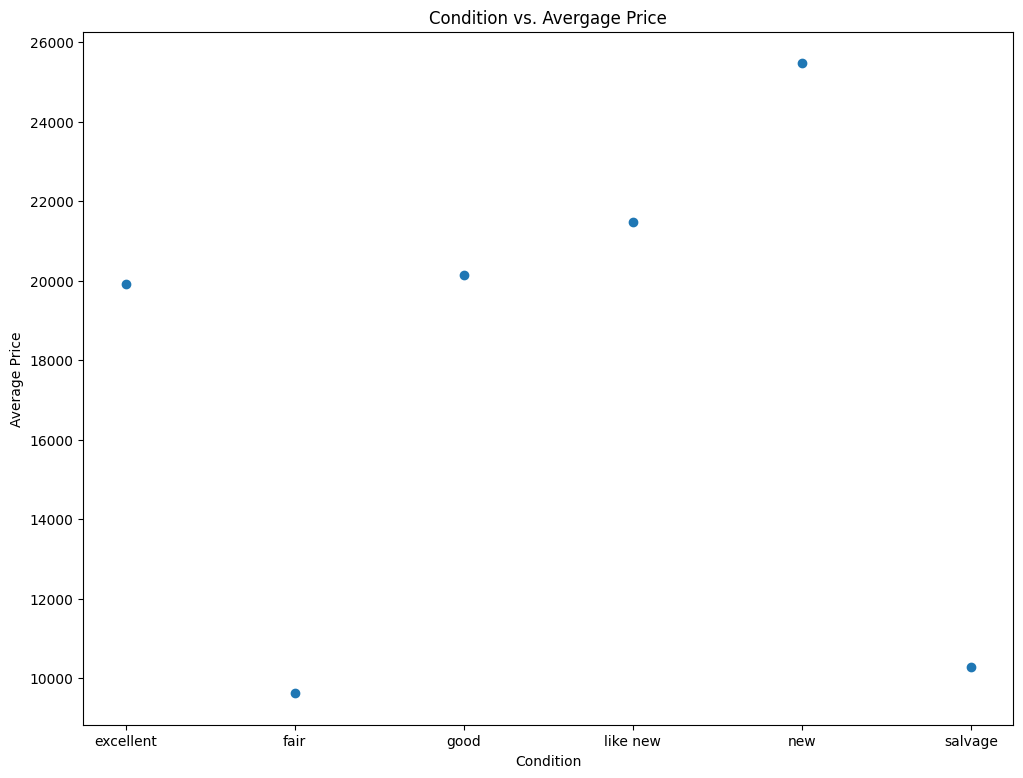

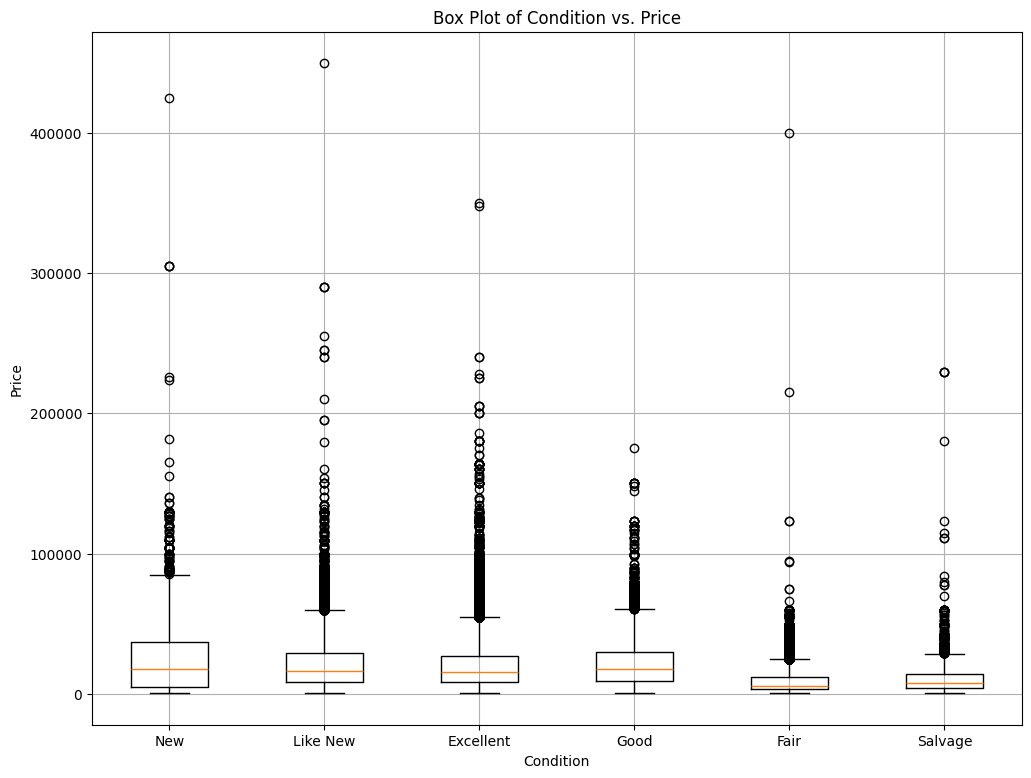

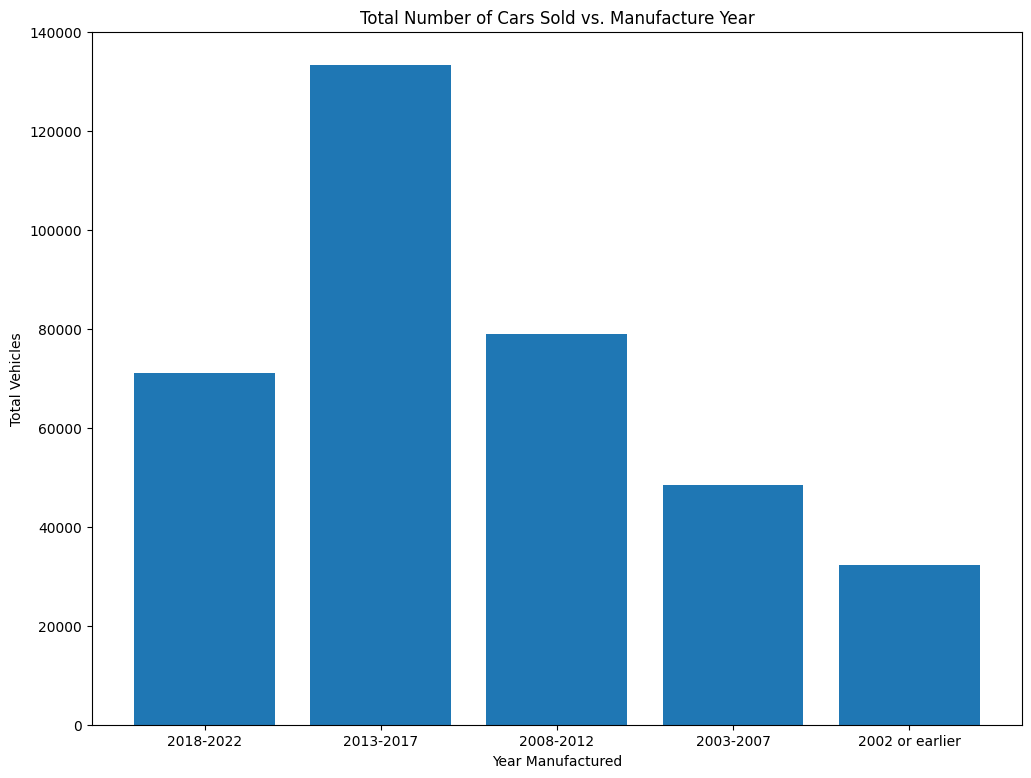

In [11]:
#code for analysis
data = data[data["price"] < 500000]
plt.figure(1)
plt.figure(figsize=(12, 9))
plt.scatter(data["year"], data["price"])
plt.title("Year Manufactured vs. Price")
plt.ylabel("Price")
plt.xlabel("Year Manufactured")

plt.figure(2)
plt.figure(figsize=(12, 9))
plt.scatter(data["odometer"], data["price"])
plt.title("Odometer Reading vs. Price")
plt.ylabel("Price")
plt.xlabel("Distanced Traveled (Mi)")

plt.figure(3)
plt.figure(figsize=(12, 9))
plt.scatter(list(data.groupby("condition")["price"].groups.keys()), data.groupby("condition")["price"].mean().tolist())
plt.title("Condition vs. Avergage Price")
plt.ylabel("Average Price")
plt.xlabel("Condition")

plt.figure(4)
plt.figure(figsize=(12, 9))
new_condition = data.loc[data["condition"] == "new", ['price']]
like_new_condition = data.loc[data["condition"] == "like new", ['price']]
excellent_condition = data.loc[data["condition"] == "excellent", ['price']]
good_condition = data.loc[data["condition"] == "good", ['price']]
fair_condition = data.loc[data["condition"] == "fair", ['price']]
salvage_condition = data.loc[data["condition"] == "salvage", ['price']]
plt.boxplot([new_condition["price"], like_new_condition["price"], excellent_condition["price"], good_condition["price"], fair_condition["price"], salvage_condition["price"]])
plt.xticks([1, 2, 3, 4, 5, 6],["New", "Like New", "Excellent", "Good", "Fair", "Salvage"])

plt.title("Box Plot of Condition vs. Price")
plt.ylabel("Price")
plt.xlabel("Condition")
plt.grid(True)


plt.figure(5)
plt.figure(figsize=(12, 9))
x = np.array(["2018-2022", "2013-2017", "2008-2012", "2003-2007", "2002 or earlier"])
y = np.array([
    data[data["year"] > 2017]["year"].shape[0], 
    data[(data["year"] <= 2017) & (data["year"] > 2012)]["year"].shape[0], 
    data[(data["year"] <= 2012) & (data["year"] > 2007)]["year"].shape[0], 
    data[(data["year"] <= 2007) & (data["year"] > 2002)]["year"].shape[0],
    data[data["year"] <= 2002]["year"].shape[0]
])

plt.title("Total Number of Cars Sold vs. Manufacture Year")
plt.ylabel("Total Vehicles")
plt.xlabel("Year Manufactured")
plt.bar(x,y)

# Display the plot
plt.show()

In [ ]:
data['odometer'] = data['odometer'].clip(upper=250000)


In [41]:
data['odometer'] = data['odometer'].clip(upper=250000)
print(data[data['odometer']])

Empty DataFrame
Columns: [region, price, year, manufacturer, model, condition, cylinders, fuel, odometer, title_status, transmission, drive, type, paint_color, state, posting_date]
Index: []


In [54]:
print(data.columns)
print(data['region'])


Index(['region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission',
       'drive', 'type', 'paint_color', 'state', 'posting_date'],
      dtype='object')
27         auburn
28         auburn
29         auburn
30         auburn
31         auburn
           ...   
426875    wyoming
426876    wyoming
426877    wyoming
426878    wyoming
426879    wyoming
Name: region, Length: 364021, dtype: object


In [65]:
data_selected_features = data[["price", "year", "model", "manufacturer", "condition", "fuel", "odometer","type","region","drive"]]

data_subset = data_selected_features.sample(frac=0.5, random_state=42)

X = data_selected_features.drop("price", axis=1)
y = data_selected_features["price"]

upper_limit = np.percentile(y, 99)  
lower_limit = np.percentile(y, 1) 
y = np.clip(y, lower_limit, upper_limit)

categorical_features = ["model", "manufacturer", "condition", "fuel","type","region","drive"]
numerical_features = ["year", "odometer"]

In [67]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

#code for ridge linear model

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numerical_transformer = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False))  
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", Ridge())
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {'regressor__alpha': [0.01, 0.1, 1.0, 10, 100]}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)




KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

#code for xg boost model

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numerical_transformer = Pipeline([
    ("scaler", StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", XGBRegressor(random_state=42, objective='reg:squarederror'))
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

param_grid = {
    "regressor__n_estimators": [50, 100, 200],       
    "regressor__max_depth": [3, 5, 7],              
    "regressor__learning_rate": [0.01, 0.1, 0.2],  
    "regressor__subsample": [0.8, 1.0],             
    "regressor__colsample_bytree": [0.8, 1.0]      
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

print("Best Hyperparameters:", grid_search.best_params_)



Fitting 3 folds for each of 108 candidates, totalling 324 fits
RMSE: 6433.437387247484
MAE: 4264.608107563393
Best Hyperparameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 7, 'regressor__n_estimators': 200, 'regressor__subsample': 0.8}


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

#code for random forest model

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


model_pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor(random_state=42))]
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


model_pipeline.fit(X_train, y_train)


y_pred = model_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mae)

4950.289597117399


In [14]:
#code for validation